In [1]:
%run preamble_2.py

In [2]:
from IPython.display import HTML

In [3]:
RESULTS = { 
    "Uniform Distribution" : load("./results/Uniform Distribution.json"),
    "API Latencies" : load("./results/API Latencies.json"),
    "Simulated Latencies" : load("./results/Simulated Latencies.json")
}

# SIZE

In [4]:
METHODS_SEL = [
 'exact',
 'prom',
 'tdigest',
 'hdr',
 'dd',
 'circllhist',
]

x = None
for ds, stats in RESULTS.items():
    y = stats_size(stats).rename({"bsize" : ds})
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)
        
df = x[METHODS_SEL].transpose()

In [5]:
df.to_latex("./tables/all_size.tex", float_format="%d")
df

,Uniform Distribution,API Latencies,Simulated Latencies
exact,800000.0,37278488.0,8141632.0
prom,88.0,88.0,88.0
tdigest,2240.0,2368.0,2080.0
hdr,615.0,2994.0,3723.0
dd,720.0,1902.0,3370.0
circllhist,453.0,1866.0,3435.0


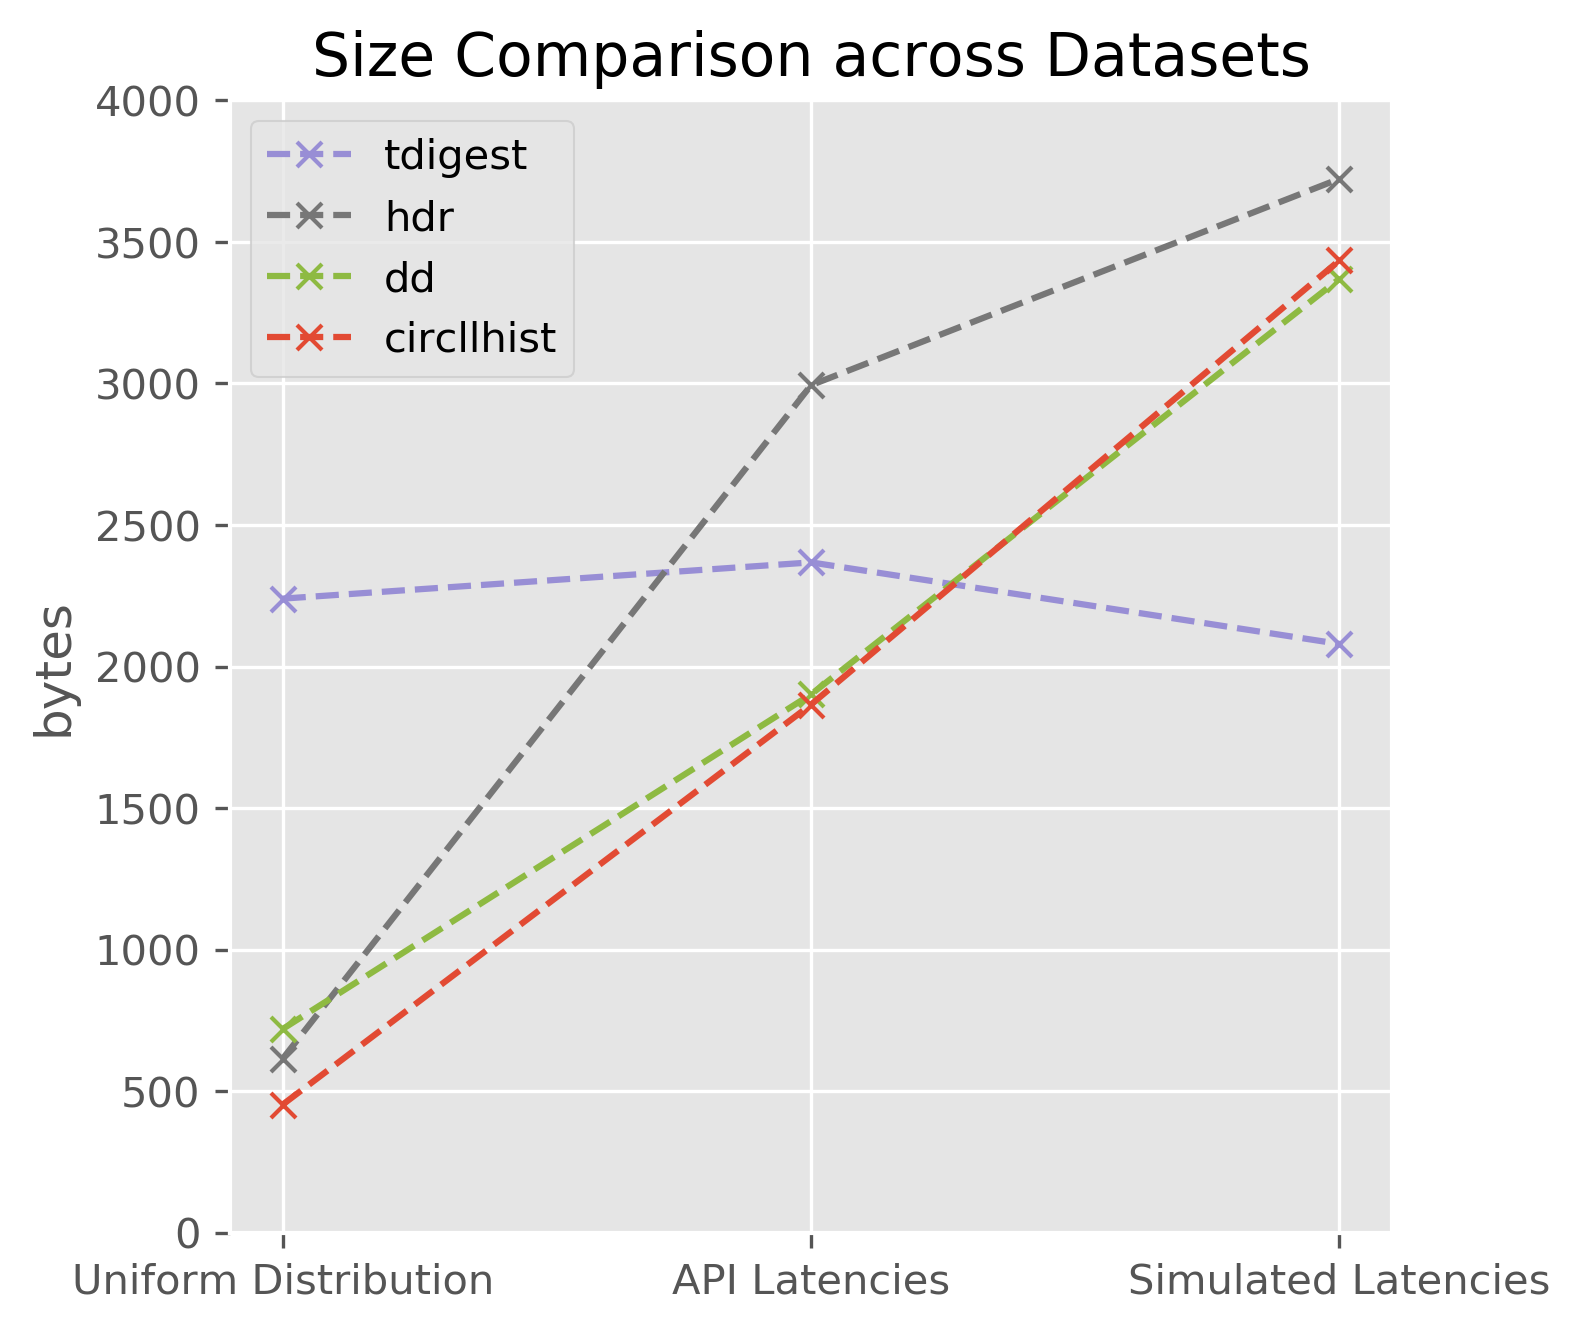

In [6]:
df2 = df.transpose()[["tdigest", "hdr", "dd", "circllhist"]]

fig = plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot(1,1,1)
df2.plot(kind="line", marker="x", style="--", ax=ax, color=['C2', 'C3', 'C5', 'C0'])
plt.title("Size Comparison across Datasets")
plt.xlim(-0.1,2.1)
plt.ylabel("bytes")
plt.ylim(0, 4000)
plt.xticks([0,1,2], ["Uniform Distribution", "API Latencies",  "Simulated Latencies"])
plt.savefig("images/all_size_line", bbox_inches = "tight")

# Performance

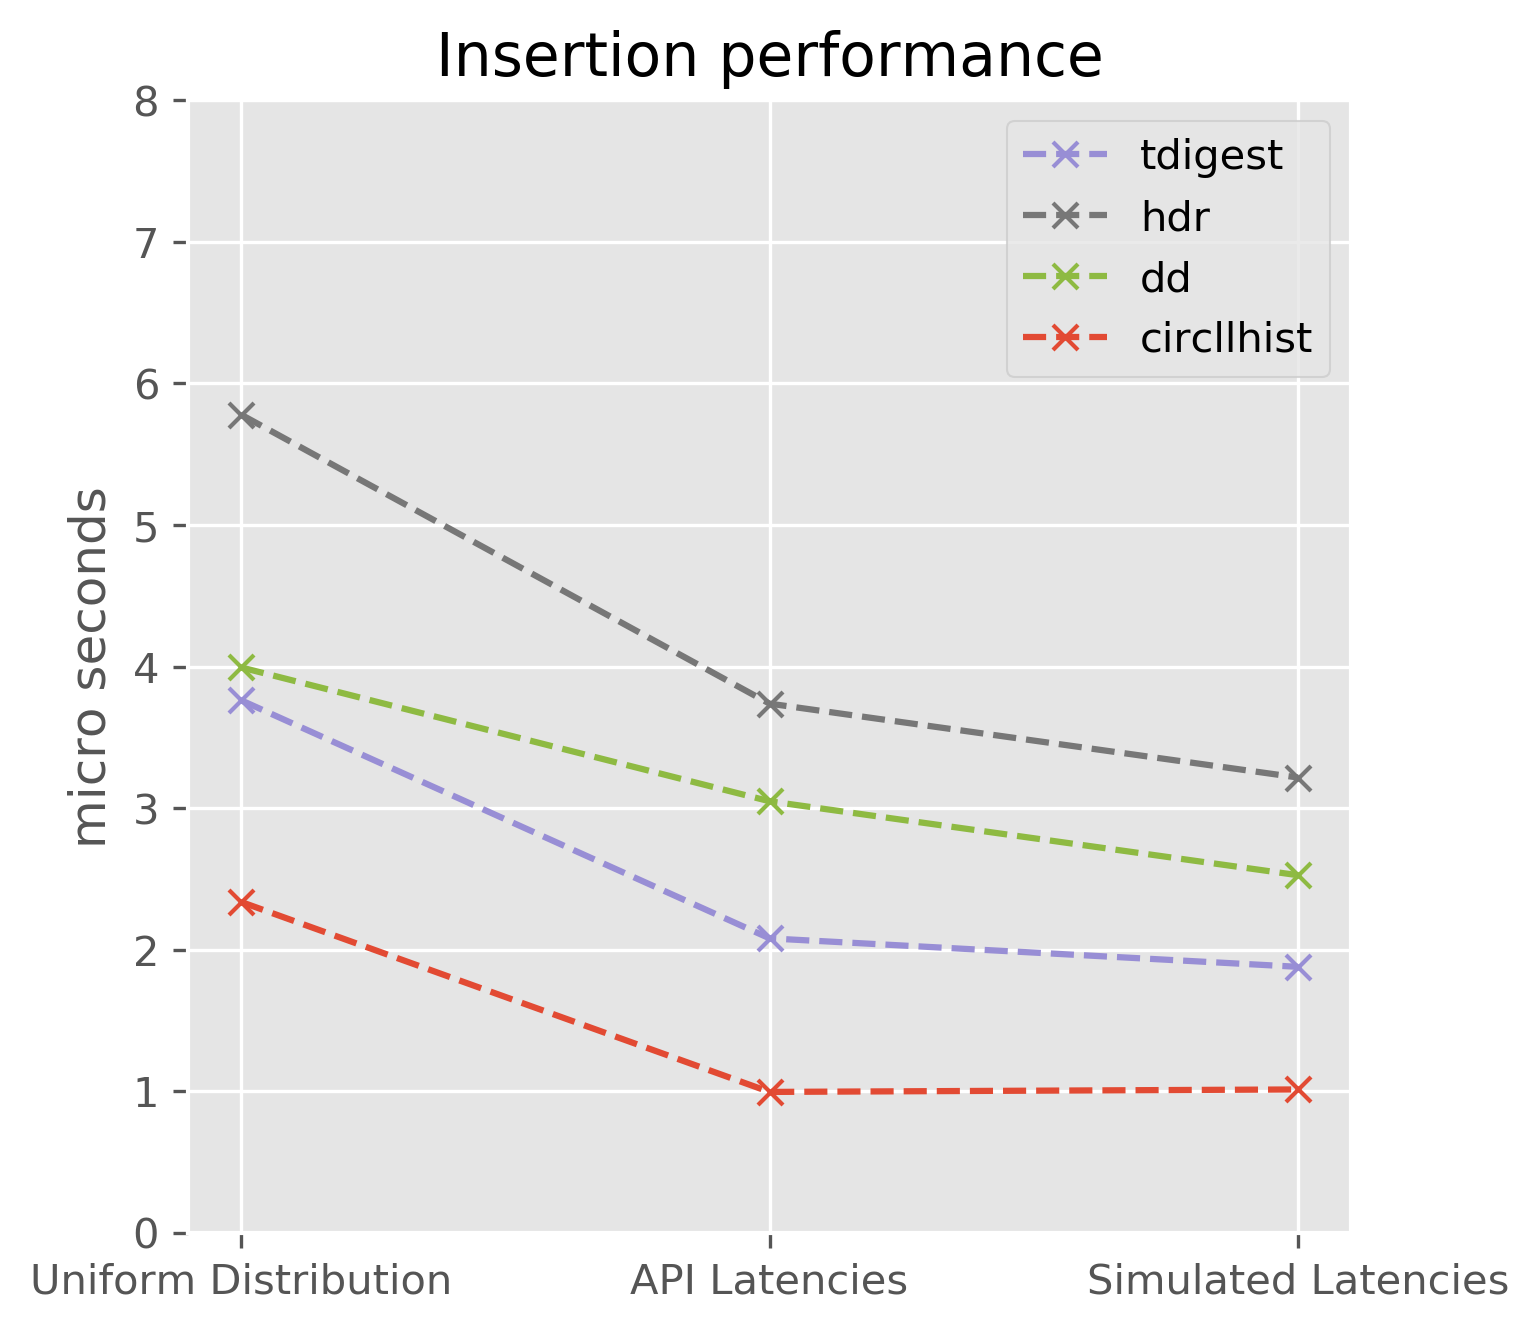

In [7]:
METHODS_SEL = [
 'exact',
 'prom',
 'tdigest',
 'hdr',
 'dd',
 'circllhist'
]

x = None
for ds, stats in RESULTS.items():
    y = stats_timing(stats).transpose()[["insert"]].transpose().rename({"insert": ds})
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)
x = x * 1000000

df = x[METHODS_SEL]
df2 = df[["tdigest", "hdr", "dd", "circllhist"]]

fig = plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot(1,1,1)
df2.plot(kind="line", marker="x", style="--", ax=ax, color=['C2', 'C3', 'C5', 'C0'])
plt.title("Insertion performance")
plt.xlim(-0.1,2.1)
plt.ylabel("micro seconds")
plt.ylim(0, 8)
plt.xticks([0,1,2], ["Uniform Distribution", "API Latencies",  "Simulated Latencies"])

plt.savefig("images/all_perf_insert", bbox_inches = "tight")

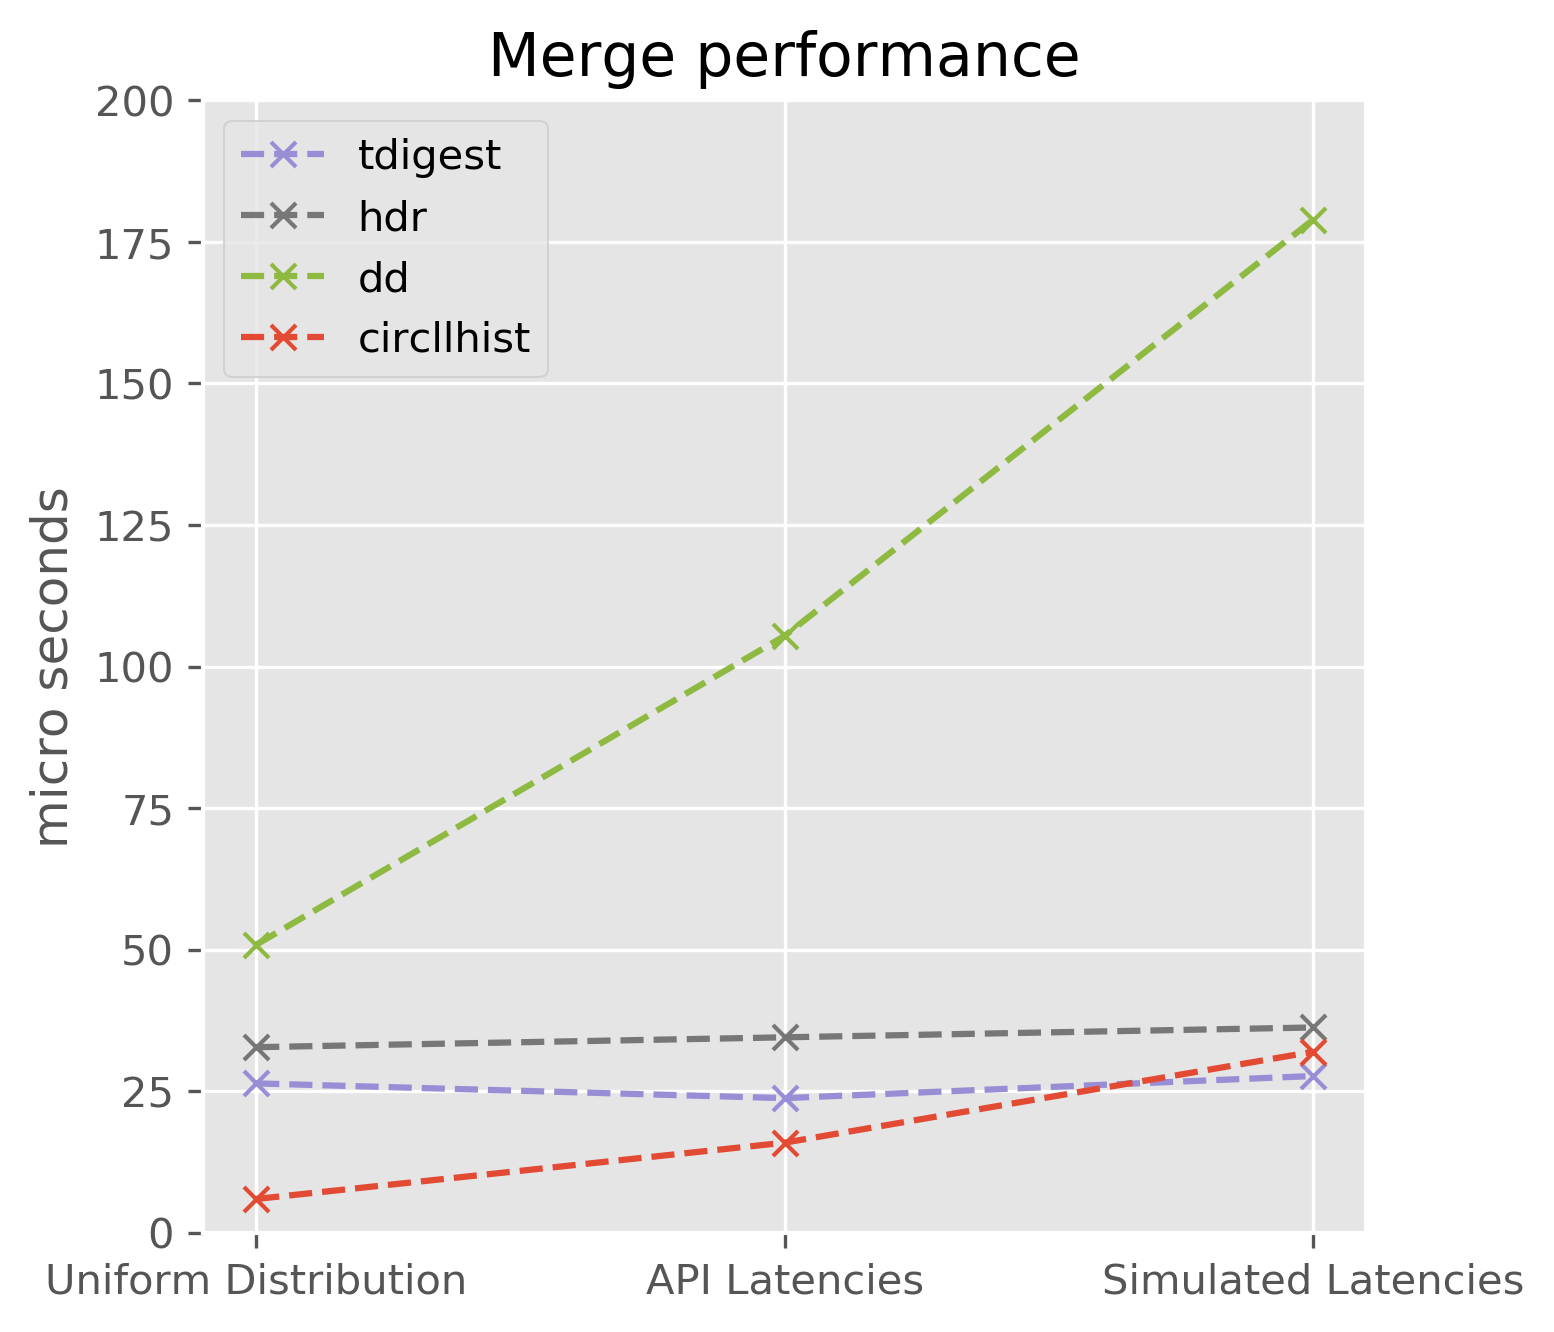

In [8]:
x = None
for ds, stats in RESULTS.items():
    y = stats_timing(stats).transpose()[["merge"]].transpose().rename({"insert": ds})
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)

x = x * 1000000
df = x[METHODS_SEL]
df2 = df[["tdigest", "hdr", "dd", "circllhist"]]

fig = plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot(1,1,1)
df2.plot(kind="line", marker="x", style="--", ax=ax, color=['C2', 'C3', 'C5', 'C0'])
plt.title("Merge performance")
plt.xlim(-0.1,2.1)
plt.ylabel("micro seconds")
plt.ylim(0, 200)
plt.xticks([0,1,2], ["Uniform Distribution", "API Latencies",  "Simulated Latencies"])

plt.savefig("images/all_perf_merge", bbox_inches = "tight")

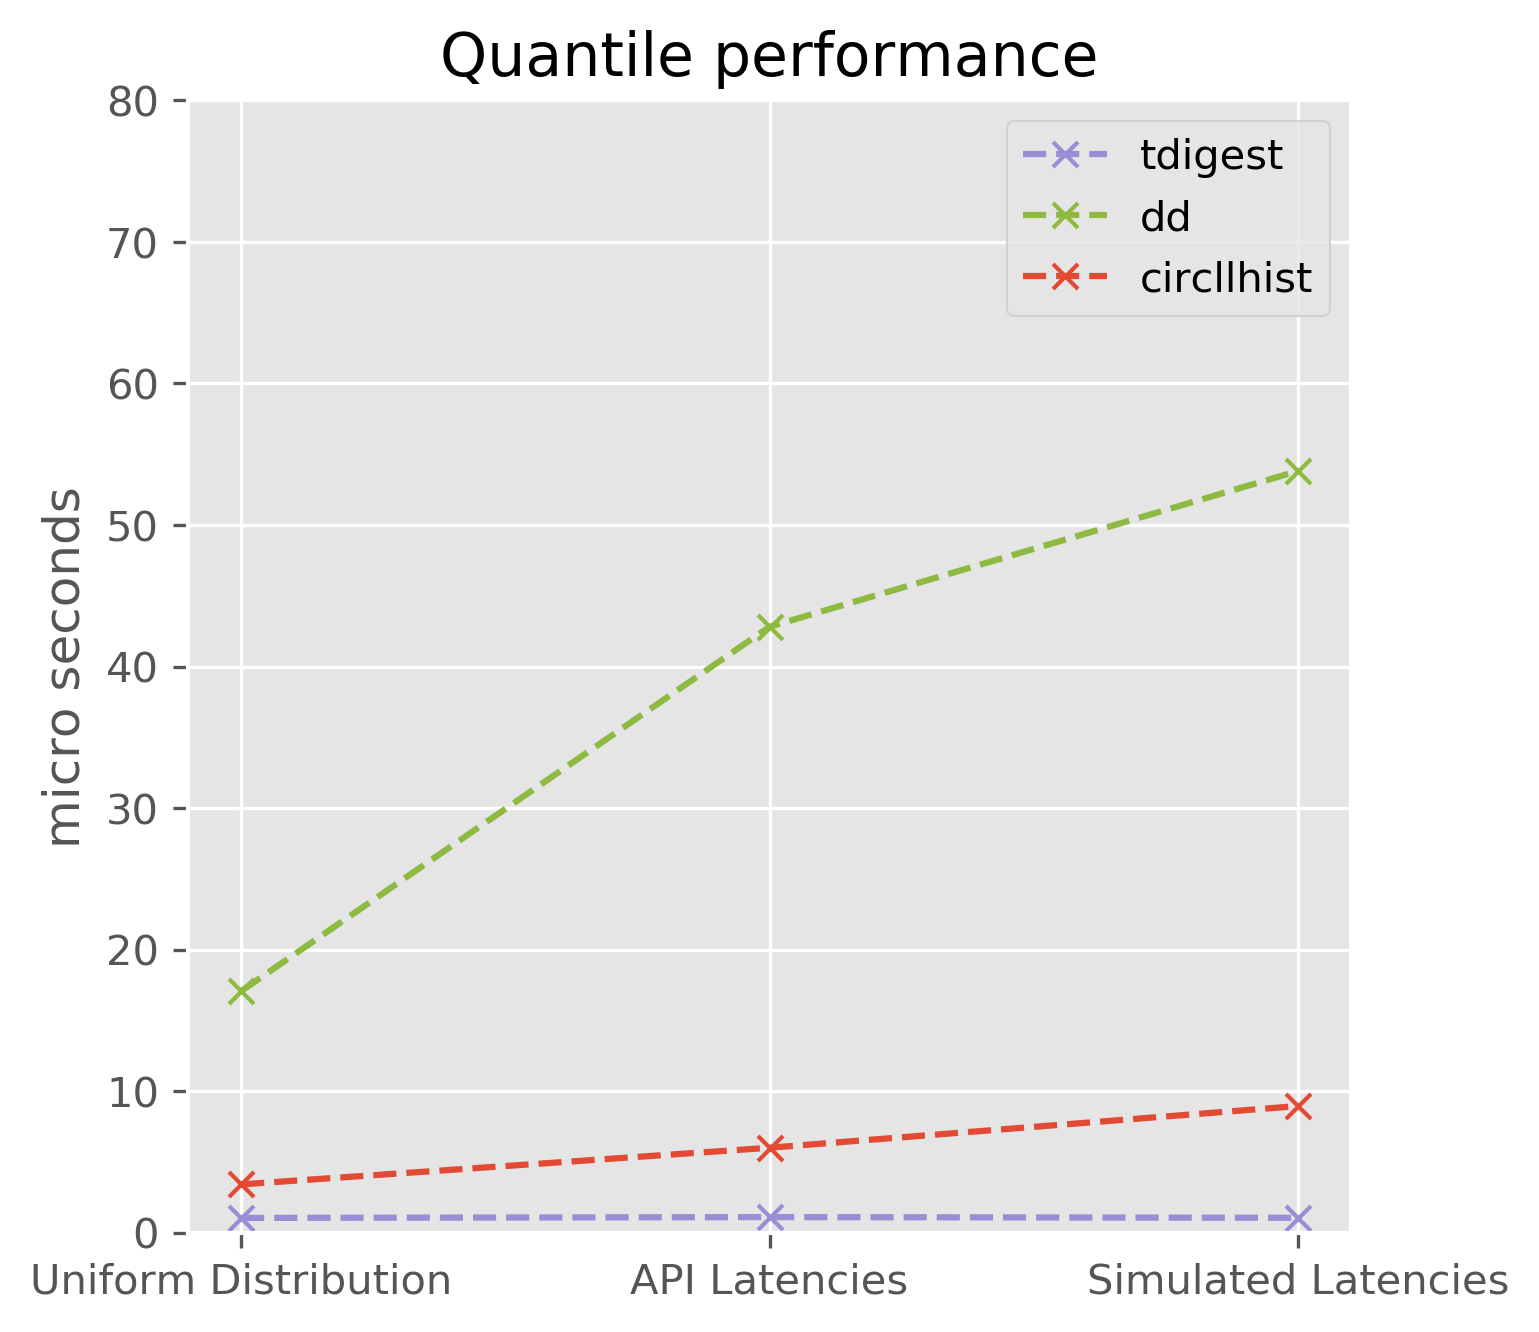

In [9]:
x = None
for ds, stats in RESULTS.items():
    y = stats_timing(stats).transpose()[["quantiles"]].transpose()
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)
x = x * 1000000
df = x[METHODS_SEL]
df2 = df[["tdigest", "dd", "circllhist"]]

fig = plt.figure(figsize=(5, 5), dpi=300)
ax = plt.subplot(1,1,1)
df2.plot(kind="line", marker="x", style="--", ax=ax, color=['C2', 'C5', 'C0'])
plt.title("Quantile performance")
plt.xlim(-0.1,2.1)
plt.ylabel("micro seconds")

plt.ylim(0, 80)
plt.xticks([0,1,2], ["Uniform Distribution", "API Latencies",  "Simulated Latencies"])

plt.savefig("images/all_perf_quantile", bbox_inches = "tight")

In [10]:
METHODS_SEL = [
 'exact',
 'prom',
 'tdigest',
 'hdr',
 'dd',
 'circllhist',
]

x = None
idx = []
for ds, stats in RESULTS.items():
    y = stats_timing(stats).rename({"insert": ds})
    i = pd.MultiIndex.from_product([[ds], ['Insertion', 'Merge', 'Quantile']], names=["Dataset","Phase"])
    y = y.set_index(i)
    for m in y.columns.to_list(): idx.append([ ds, m ])
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)

x = x[METHODS_SEL]
df = x.transpose() * 1000000

df = df.reorder_levels([1, 0],axis=1).sort_index(level=0,axis=1)
df = df.reindex(["Uniform Distribution", "API Latencies", "Simulated Latencies"], axis=1, level=1)
df.columns.set_levels(["Unif. D.", "API L.", "Sim. L."], level=1, inplace=True)

In [11]:
FMT = "%.1f"
df.to_latex("./tables/all_perf.tex", float_format=FMT)
HTML( df.to_html(float_format=FMT) )

# ACCURACY

In [12]:
METHODS_SEL = [
 'tdigest',
 'hdr',
 'dd',
 'circllhist'
]

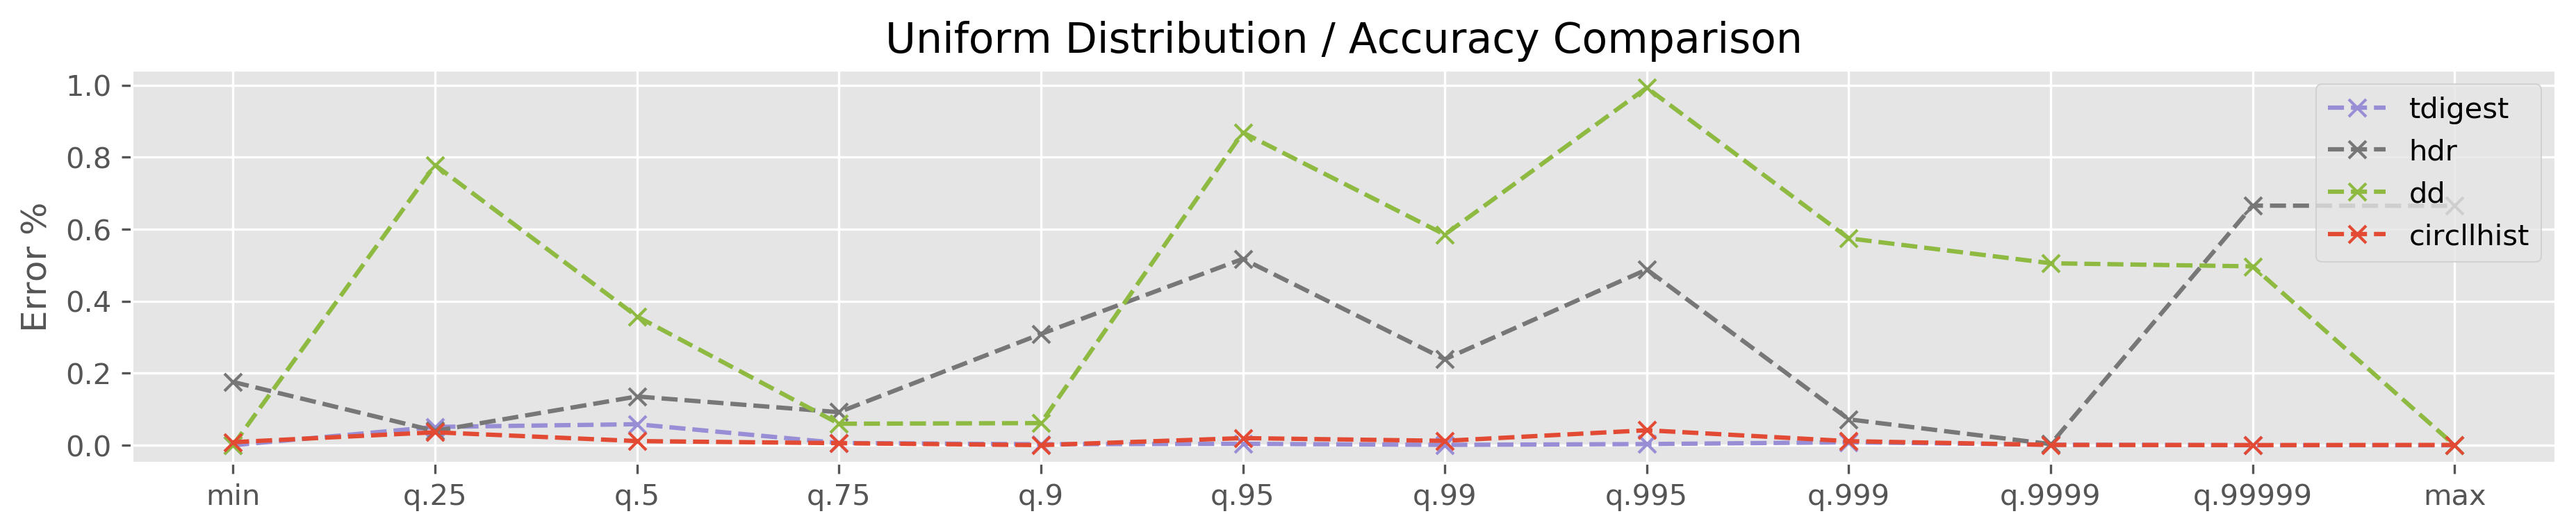

In [13]:
DS_NAME = 'Uniform Distribution'
LABEL = 'min q.25 q.5 q.75 q.9 q.95 q.99 q.995 q.999 q.9999 q.99999 max'.split()

df = stats_qerr(RESULTS[DS_NAME])[METHODS_SEL]
fig = plt.figure(figsize=(15, 2.5), dpi=300)
ax = plt.subplot(1,1,1)
plt.title(DS_NAME + " / Accuracy Comparison")
df.plot(kind="line", marker="x", style="--", ax = ax, color=['C2', 'C3', 'C5', 'C0'])
plt.xlim(-0.5,11.5)
plt.xticks(range(12), LABEL)
plt.legend(loc="upper right")
plt.ylabel("Error %")

plt.savefig("images/accuracy_line_" + DS_NAME, bbox_inches="tight")

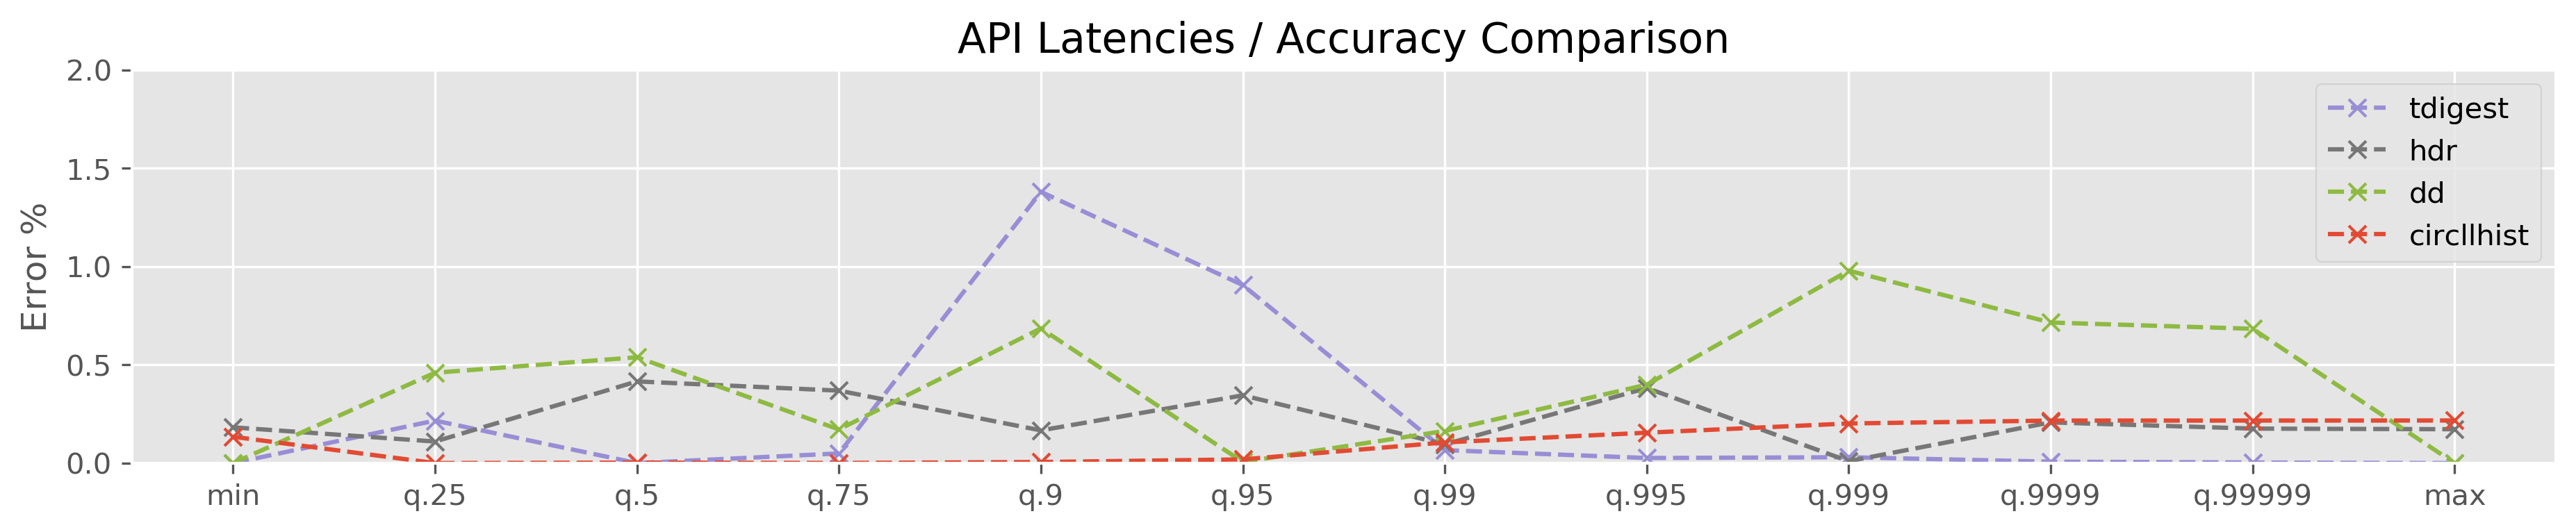

In [14]:
DS_NAME = 'API Latencies'

LABEL = 'min q.25 q.5 q.75 q.9 q.95 q.99 q.995 q.999 q.9999 q.99999 max'.split()

df = stats_qerr(RESULTS[DS_NAME])[METHODS_SEL]
fig = plt.figure(figsize=(15, 2.5), dpi=300)
ax = plt.subplot(1,1,1)
plt.title(DS_NAME + " / Accuracy Comparison")
df.plot(kind="line", marker="x", style="--", ax = ax, color=['C2', 'C3', 'C5', 'C0'])
plt.xlim(-0.5,11.5)
plt.ylim(0,2)
plt.legend(loc="upper right")
plt.ylabel("Error %")
plt.xticks(range(12), LABEL)

plt.savefig("images/accuracy_line_" + DS_NAME, bbox_inches="tight")

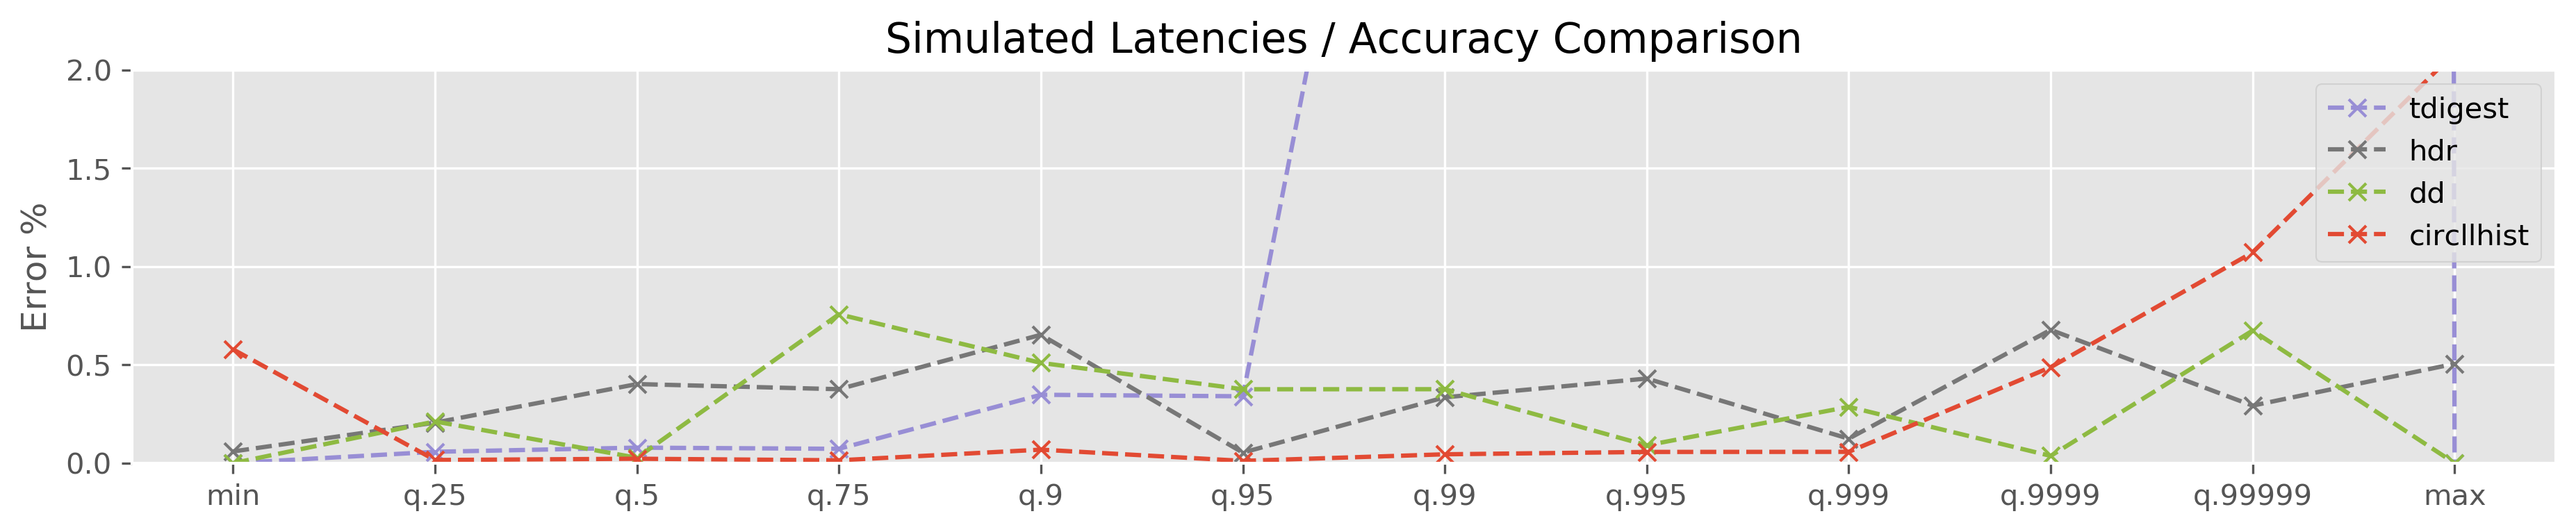

In [15]:
DS_NAME = 'Simulated Latencies'

LABEL = 'min q.25 q.5 q.75 q.9 q.95 q.99 q.995 q.999 q.9999 q.99999 max'.split()

df = stats_qerr(RESULTS[DS_NAME])[METHODS_SEL]
fig = plt.figure(figsize=(15, 2.5), dpi=300)
ax = plt.subplot(1,1,1)
plt.title(DS_NAME + " / Accuracy Comparison")
df.plot(kind="line", marker="x", style="--", ax = ax, color=['C2', 'C3', 'C5', 'C0'])
plt.xlim(-0.5,11.5)
plt.legend(loc="upper right")
plt.ylabel("Error %")
plt.xticks(range(12), LABEL)
plt.ylim(0, 2)

plt.savefig("images/accuracy_line_" + DS_NAME, bbox_inches="tight")

In [16]:
METHODS_SEL = [
 'prom',
 'tdigest',
 'hdr',
 'dd',
 'circllhist',
]

x = None
idx = []
for ds, stats in RESULTS.items():
    y = stats_qerr(stats)
    i = pd.MultiIndex.from_product([[ds], y.index.to_list()])
    y = y.set_index(i)
    for m in y.columns.to_list(): idx.append([ ds, m ])
    if type(x) == type(None):
        x = y
    else:
        x = x.append(y)

df = x[METHODS_SEL]
df = df.swaplevel(0,1).unstack().transpose().swaplevel(0,1)
df = df.stack().unstack().reindex(["Uniform Distribution", "API Latencies", "Simulated Latencies"], axis=0, level=0)

df.columns.set_names(["Quantile"], inplace=True)

In [17]:
FMT = "%.2f"

df.to_latex("./tables/all_acc.tex", float_format=FMT)

HTML(df.to_html(float_format=FMT))